# ResNet Ablation Study


## 목차

0. 데이터셋 준비
1. ResNet 기본 블록 구성하기
2. ResNet-34, ResNet-50 Complete Model
3. 일반 네트워크(plain network) 만들기
4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Planin-34
5. 회고

## 루브릭

|평가문항|상세기준|
|:----|:----|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

## 0. 데이터셋 준비

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


aiffel 세팅 tf: 2.6.0, np: 1.21.4

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteAN627X/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 1. ResNet 기본 블록 구성하기

In [8]:
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_50=False, 
                    is_plain=False
                   ):
    x = input_layer

    shortcut = x

    if is_50:
        for i in range(num_cnn):
            if (i == 0):
                s = (2, 2)
                if block_num == 0:
                    s = (1, 1)    
                x = Conv2D(channel, (1,1), strides=s, padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(channel*4, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                if is_plain:
                    x = Activation('relu')(x)
                else:
                    shortcut = Conv2D(channel*4, (1, 1), strides=s, padding='valid')(shortcut)            
                    shortcut = BatchNormalization()(shortcut)

                    x = Add()([x, shortcut])
                    x = Activation('relu')(x)

                    shortcut = x
            else:
                x = Conv2D(channel, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                
                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
    
                x = Conv2D(channel * 4, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)            
                if is_plain:
                    x = Activation('relu')(x)
                else:  
                    x = Add()([x, shortcut])   
                    x = Activation('relu')(x)  
        
                    shortcut = x

    else:
        for i in range(num_cnn):
            if (i == 0):
                s = (2, 2)
                if block_num == 0:
                    s = (1, 1)    
                x = Conv2D(channel, (3, 3), strides=s, padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                if is_plain:
                    x = Activation('relu')(x)
                else:
                    shortcut = Conv2D(channel, (1, 1), strides=s, padding='same')(shortcut)            
                    shortcut = BatchNormalization()(shortcut)

                    x = Add()([x, shortcut])
                    x = Activation('relu')(x)

                    shortcut = x
            else:
                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                
                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)            
                if is_plain:
                    x = Activation('relu')(x)
                else:  
                    x = Add()([x, shortcut])   
                    x = Activation('relu')(x)  
        
                    shortcut = x
    return x

In [9]:
def build_resnet(input_shape=(32,32,3), num_classes=2, is_50=False, is_plain=False):
    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]
    num_classes = num_classes

    input_layer = keras.layers.Input(shape=input_shape, name='input')
    output = input_layer
    
    output = ZeroPadding2D(padding=(3, 3))(output)
    output = keras.layers.Conv2D(
        filters=64, 
        kernel_size=(7,7),
        strides=2)(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    
    output = ZeroPadding2D(padding=(1, 1))(output)
    output = MaxPooling2D((3, 3), 2)(output)
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            is_50 = is_50,
            is_plain=is_plain
        )
    output = GlobalAveragePooling2D()(output)
    output = Dense(num_classes, activation='softmax')(output)
    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

## 2. ResNet-34, ResNet-50 Complete Modle

In [10]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False, is_plain=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [11]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=False)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

## 3. 일반 네트워크(plain network) 만들기

In [12]:
resnet_34_plain = build_resnet(input_shape=(224, 224, 3), is_50=False, is_plain=True)
resnet_34_plain.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 230, 230, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_90 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 114, 114, 64)     0   

In [13]:
resnet_50_plain = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=True)
resnet_50_plain.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_6 (ZeroPaddi  (None, 230, 230, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_123 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_123 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 zero_padding2d_7 (ZeroPaddi  (None, 114, 114, 64)     0   

## 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [14]:
BATCH_SIZE = 32
EPOCH = 20

In [15]:
ds_train = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, True, BATCH_SIZE)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### ResNet-34 vs Plain-34

In [18]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 91s 116ms/step - loss: 0.6681 - accuracy: 0.5967 - val_loss: 0.6892 - val_accuracy: 0.5619
Epoch 2/20
581/581 [==============================] - 66s 113ms/step - loss: 0.6319 - accuracy: 0.6403 - val_loss: 0.6322 - val_accuracy: 0.6403
Epoch 3/20
581/581 [==============================] - 66s 114ms/step - loss: 0.6078 - accuracy: 0.6655 - val_loss: 0.6284 - val_accuracy: 0.6530
Epoch 4/20
581/581 [==============================] - 66s 114ms/step - loss: 0.5956 - accuracy: 0.6788 - val_loss: 0.6117 - val_accuracy: 0.6603
Epoch 5/20
581/581 [==============================] - 66s 113ms/step - loss: 0.5762 - accuracy: 0.6927 - val_loss: 0.6028 - val_accuracy: 0.6823
Epoch 6/20
581/581 [==============================] - 66s 114ms/step - loss: 0.5539 - accuracy: 0.7177 - val_loss: 0.6243 - val_accuracy: 0.6683
Epoch 7/20
581/581 [==============================] - 66s 114ms/step - loss: 0.5294 - accuracy: 0.7305 - val_loss: 0.5827 - val_accuracy: 0.6

In [20]:
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet_34_plain.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 81s 110ms/step - loss: 0.6882 - accuracy: 0.5512 - val_loss: 0.7152 - val_accuracy: 0.4927
Epoch 2/20
581/581 [==============================] - 63s 108ms/step - loss: 0.6854 - accuracy: 0.5546 - val_loss: 0.6881 - val_accuracy: 0.5638
Epoch 3/20
581/581 [==============================] - 63s 108ms/step - loss: 0.6876 - accuracy: 0.5500 - val_loss: 0.6868 - val_accuracy: 0.5455
Epoch 4/20
581/581 [==============================] - 63s 108ms/step - loss: 0.6845 - accuracy: 0.5559 - val_loss: 0.7019 - val_accuracy: 0.5356
Epoch 5/20
581/581 [==============================] - 62s 108ms/step - loss: 0.6813 - accuracy: 0.5647 - val_loss: 0.6798 - val_accuracy: 0.5631
Epoch 6/20
581/581 [==============================] - 62s 107ms/step - loss: 0.6812 - accuracy: 0.5641 - val_loss: 0.6919 - val_accuracy: 0.5765
Epoch 7/20
581/581 [==============================] - 62s 107ms/step - loss: 0.6801 - accuracy: 0.5681 - val_loss: 0.6798 - val_accuracy: 0.5

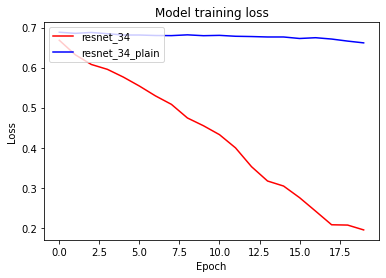

In [21]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_plain'], loc='upper left')
plt.show()

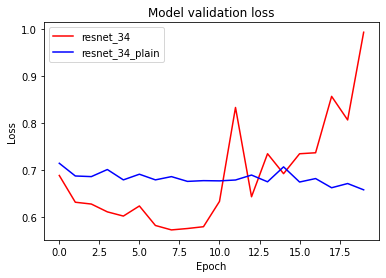

In [27]:
plt.plot(history_34.history['val_loss'], 'r')
plt.plot(history_34_plain.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_plain'], loc='upper left')
plt.show()

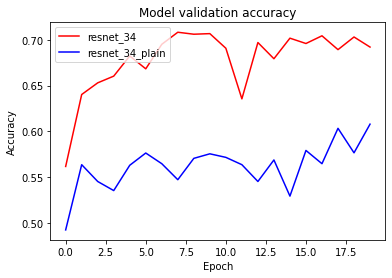

In [22]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_plain'], loc='upper left')
plt.show()

### ResNet-50 vs Plain-50

In [23]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 125s 184ms/step - loss: 0.6835 - accuracy: 0.5667 - val_loss: 0.7152 - val_accuracy: 0.5078
Epoch 2/20
581/581 [==============================] - 106s 183ms/step - loss: 0.6714 - accuracy: 0.5892 - val_loss: 0.6838 - val_accuracy: 0.5647
Epoch 3/20
581/581 [==============================] - 106s 183ms/step - loss: 0.6645 - accuracy: 0.6005 - val_loss: 0.6643 - val_accuracy: 0.6123
Epoch 4/20
581/581 [==============================] - 106s 182ms/step - loss: 0.6537 - accuracy: 0.6161 - val_loss: 0.6705 - val_accuracy: 0.6075
Epoch 5/20
581/581 [==============================] - 106s 182ms/step - loss: 0.6504 - accuracy: 0.6239 - val_loss: 0.6490 - val_accuracy: 0.6235
Epoch 6/20
581/581 [==============================] - 106s 182ms/step - loss: 0.6443 - accuracy: 0.6308 - val_loss: 0.6368 - val_accuracy: 0.6384
Epoch 7/20
581/581 [==============================] - 105s 182ms/step - loss: 0.6366 - accuracy: 0.6372 - val_loss: 0.6433 - val_accura

In [24]:
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet_50_plain.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 110s 162ms/step - loss: 0.6934 - accuracy: 0.5369 - val_loss: 0.7059 - val_accuracy: 0.4892
Epoch 2/20
581/581 [==============================] - 90s 155ms/step - loss: 0.6856 - accuracy: 0.5553 - val_loss: 0.6987 - val_accuracy: 0.5562
Epoch 3/20
581/581 [==============================] - 90s 156ms/step - loss: 0.6854 - accuracy: 0.5526 - val_loss: 0.6901 - val_accuracy: 0.5476
Epoch 4/20
581/581 [==============================] - 90s 155ms/step - loss: 0.6852 - accuracy: 0.5591 - val_loss: 0.7004 - val_accuracy: 0.5422
Epoch 5/20
581/581 [==============================] - 93s 161ms/step - loss: 0.6857 - accuracy: 0.5526 - val_loss: 0.6950 - val_accuracy: 0.5612
Epoch 6/20
581/581 [==============================] - 94s 161ms/step - loss: 0.6843 - accuracy: 0.5571 - val_loss: 0.6921 - val_accuracy: 0.5483
Epoch 7/20
581/581 [==============================] - 90s 155ms/step - loss: 0.6855 - accuracy: 0.5547 - val_loss: 0.7012 - val_accuracy: 0.

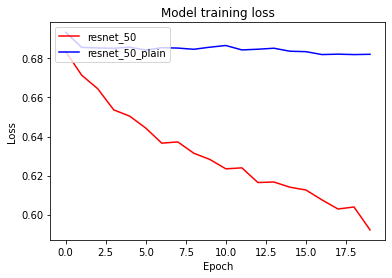

In [25]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_plain'], loc='upper left')
plt.show()

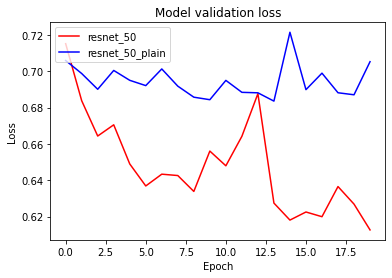

In [28]:
plt.plot(history_50.history['val_loss'], 'r')
plt.plot(history_50_plain.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_plain'], loc='upper left')
plt.show()

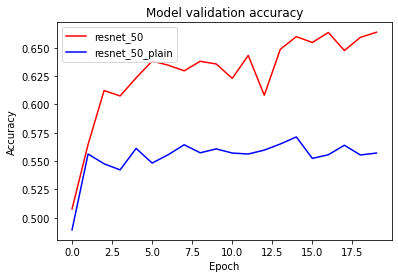

In [26]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_plain'], loc='upper left')
plt.show()

### ResNet-34 vs ResNet-50

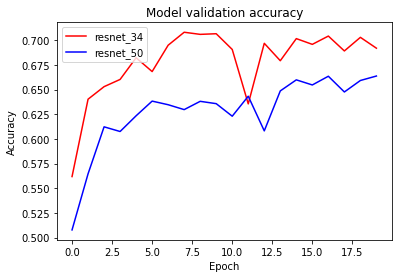

In [29]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

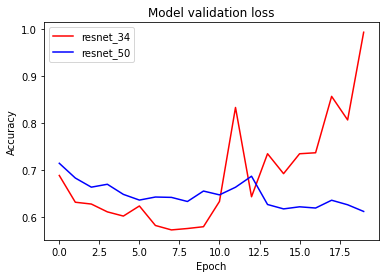

In [30]:
plt.plot(history_34.history['val_loss'], 'r')
plt.plot(history_50.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

## 5. 회고

- 코랩으로 사용 시 RAM 초과를 조심해야 할 것 같습니다.
- resnet-34의 경우 validation loss 값이 많이 상승하는 것을 볼 수 있다.
- 하지만 validation accuracy의 경우 Epoch 수에 비해 좋은 결과가 나온 것 같습니다.
- resnet-50의 경우 Epoch 수가 증가하면 resnet-34 보다 validation accuracy가 좋아질 것 같습니다. 
- resnet-50은 validation loss가 안정적으로 줄어드는 것을 확인했습니다.
- resnet 모델이 Plain 모델보다 성능이 좋은 것을 시각화를 통해서 확인했습니다.
- train loss의 경우 resnet-34와 resnet-50 둘 다 안정적으로 감소했습니다.
- 이번 프로젝트는 논문을 보고 만들어야 했지만, 논문만 보고 만들지 못했습니다.
    - 이번 프로젝트를 시작으로 논문을 보고 모델을 구현할 수 있도록 많은 공부가 필요할 것 같습니다.
